<a href="https://colab.research.google.com/github/dan-a-iancu/airm/blob/master/Uber_Minicase/Uber_Dispatch_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements the solution to the **UBER Dispatch and Pricing** mini-case. It assumes you are familiar with the case and the model.

____
# Basic Setup

Import useful modules, read the data and store it in data frames, and set up some useful Python lists. You may want to expand this section and make sure you understand how the data is organized, and also read the last part where the Python lists are created, as these may be very useful when you build your model.

In [1]:
#@markdown We first import some useful modules. 

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# import numpy
import numpy as np
import urllib.request  # for file downloading

# Import pandas for data-frames
import pandas as pd
pd.options.display.max_rows = 15
pd.options.display.float_format = "{:,.2f}".format

from IPython.display import display

# Make sure Matplotlib runs inline, for nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.ticker as ticker 

# install Gurobi (our linear optimization solver)
!pip install -i https://pypi.gurobi.com gurobipy
from gurobipy import *

# some modules to create local directories for CBC (to avoid issues with solving multiple models)
import os
def new_local_directory(name):
    full_path = os.path.join(".", name)
    os.makedirs(full_path, exist_ok=True)
    return full_path

# install the latest version of seaborn for nicer graphics
#!pip install --prefix {sys.prefix} seaborn==0.11.0  &> /dev/null
import seaborn as sns

# Ignore useless some warnings
import warnings
warnings.simplefilter(action="ignore")

print("Completed successfully!")

Looking in indexes: https://pypi.gurobi.com
Completed successfully!


## Load the case data into Pandas data frames

We first download an Excel file with all the data from Github.

In [2]:
#@markdown Download the entire data as an Excel file from Github

url_Excel = 'https://github.com/dan-a-iancu/airm/blob/master/Uber_Minicase/Uber_Dispatching_Data.xlsx?raw=true'
local_file = "Uber_Data.xlsx"   # name of local file where you want to store the downloaded file
urllib.request.urlretrieve(url_Excel, local_file)    # download from website and save it locally

('Uber_Data.xlsx', <http.client.HTTPMessage at 0x7f9ba01e7990>)

Read in and store the data in suitable dataframes.

In [3]:
#@markdown Create dataframes based on the Excel file

# data on drivers
drivers_df = pd.read_excel("Uber_Data.xlsx", sheet_name = "Drivers", index_col=0)
print("The drivers")
display(drivers_df)

# data on riders
riders_df = pd.read_excel("Uber_Data.xlsx", sheet_name = "Riders", index_col=0)
print("The riders")
display(riders_df)

# the match that the data scientist created
ds_match_df = pd.read_excel("Uber_Data.xlsx", sheet_name = "Josephines_Match", index_col=0)
print("The data scientist's solution")
display(ds_match_df)

The drivers


,Location_X,Location_Y
Driver_ID,,
1,0.58,1.21
2,0.00,1.44
3,0.09,0.10
4,1.56,0.59
5,1.69,0.67
6,0.26,1.83
7,0.50,1.18
8,0.41,0.82
9,1.64,1.89


The riders


,Location_X,Location_Y,Distance_to_destination,Request_in
Passenger_ID,,,,
A,0.67,0.14,1.84,1
B,1.19,1.53,2.12,1
C,0.38,1.07,1.43,1
D,0.65,0.79,0.94,1
E,0.15,1.66,1.74,1
F,1.71,1.66,1.92,1
G,1.92,1.67,0.56,1
H,0.18,1.29,2.42,1
I,0.39,0.69,0.90,1


The data scientist's solution


,1,2,3,4,5,6,7,8,9,10
A,0,0,1,0,0,0,0,0,0,0
B,0,0,0,0,0,0,0,0,1,0
C,0,0,0,0,0,0,0,0,0,1
D,0,0,0,0,0,0,0,1,0,0
E,0,0,0,0,0,1,0,0,0,0
F,0,0,0,0,1,0,0,0,0,0
G,0,0,0,1,0,0,0,0,0,0
H,0,1,0,0,0,0,0,0,0,0
I,0,0,0,0,0,0,1,0,0,0
J,1,0,0,0,0,0,0,0,0,0


## Create Python lists and store any other relevant problem parameters

__NOTE__: Make sure you understand what the __lists__ created here are! These will be very helpful when creating the model.

In [4]:
#@markdown Create useful lists with the departments and the days of the week
# calculate the list of departments
drivers = list( drivers_df.index )
print("The list of drivers:")
print(drivers)

# calculate the list of days
riders = list( riders_df.index )
print("The list of riders:")
print(riders)

The list of drivers:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
The list of riders:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


In [5]:
#@markdown Also create a distance matrix with distances for all (driver,rider) pairs

# first create a dictionary
distances = dict( [(d, [np.sqrt( sum( (drivers_df[idx][d] - riders_df[idx][r])**2 \
                                     for idx in ["Location_X", "Location_Y"]) ) \
                        for r in riders]) for d in drivers] )

# then turn this into a dataframe
distances_df = pd.DataFrame( distances, index=riders )
display(distances_df)

,1,2,3,4,5,6,7,8,9,10
A,1.08,1.47,0.58,1.00,1.16,1.74,1.05,0.73,2.01,1.09
B,0.69,1.19,1.80,1.01,1.00,0.98,0.77,1.05,0.58,0.90
C,0.25,0.53,1.01,1.28,1.38,0.76,0.16,0.26,1.51,0.11
D,0.43,0.92,0.88,0.93,1.05,1.11,0.42,0.25,1.48,0.49
E,0.62,0.26,1.56,1.77,1.84,0.20,0.60,0.88,1.51,0.52
F,1.21,1.72,2.24,1.08,0.99,1.46,1.30,1.55,0.24,1.43
G,1.42,1.94,2.41,1.14,1.02,1.68,1.50,1.74,0.36,1.64
H,0.41,0.23,1.19,1.55,1.64,0.54,0.34,0.53,1.58,0.21
I,0.56,0.84,0.66,1.18,1.31,1.14,0.50,0.13,1.74,0.49
J,0.26,0.38,1.31,1.42,1.50,0.46,0.24,0.56,1.37,0.20


Store a few additional parameters

In [6]:
#@markdown Some extra parameters/data
# the number of drivers and riders
num_drivers = len(drivers)
num_riders = len(riders)
num_rider_requests = riders_df["Request_in"].sum()

# the fare (per km)
fare_per_km = 3.0

# the share of revenues kept by drivers
driver_share_revenue = 0.75

# average speed of drivers (km per minute)
avg_speed = 0.3

_____
# **Q1**

##  Analyze the model created by the data scientist

Calculate the minimum distance to each rider, and the driver that achieves it. 

In [7]:
#@markdown Calculate the minimum distance to each rider, and the driver that achieves it.

# make a copy of the dataframe
ds_analyze = distances_df.copy()

# the min distance
ds_analyze["Min_distance"] = ds_analyze.min(axis=1)

# the driver achieving the min distance
ds_analyze["Closest_driver"] = ds_analyze.idxmin(axis=1)

display(ds_analyze)

,1,2,3,4,5,6,7,8,9,10,Min_distance,Closest_driver
A,1.08,1.47,0.58,1.00,1.16,1.74,1.05,0.73,2.01,1.09,0.58,3
B,0.69,1.19,1.80,1.01,1.00,0.98,0.77,1.05,0.58,0.90,0.58,9
C,0.25,0.53,1.01,1.28,1.38,0.76,0.16,0.26,1.51,0.11,0.11,10
D,0.43,0.92,0.88,0.93,1.05,1.11,0.42,0.25,1.48,0.49,0.25,8
E,0.62,0.26,1.56,1.77,1.84,0.20,0.60,0.88,1.51,0.52,0.20,6
F,1.21,1.72,2.24,1.08,0.99,1.46,1.30,1.55,0.24,1.43,0.24,9
G,1.42,1.94,2.41,1.14,1.02,1.68,1.50,1.74,0.36,1.64,0.36,9
H,0.41,0.23,1.19,1.55,1.64,0.54,0.34,0.53,1.58,0.21,0.21,10
I,0.56,0.84,0.66,1.18,1.31,1.14,0.50,0.13,1.74,0.49,0.13,8
J,0.26,0.38,1.31,1.42,1.50,0.46,0.24,0.56,1.37,0.20,0.20,10


Now determine whether the data scientist is matching according to the shortest distance, on a first-come, first-served basis (i.e., first A is matched, then B is matched, etc.)

In [8]:
#@markdown Check if the matching is done first-come, first-served according to minimum distance
remaining_drivers = drivers.copy()

for r in riders:
    if riders_df["Request_in"][r]==1 :
        print("\nRider {}. Available drivers and times: ".format(r))
        print(remaining_drivers)

        shortest_time = np.min(ds_analyze.loc[r,remaining_drivers])
        best_driver = remaining_drivers[np.argmin(ds_analyze.loc[r,remaining_drivers])]

        print("Shortest time: {:.2f} (min)".format(shortest_time))
        print("Best match:    {}".format(best_driver))

        if ds_match_df[best_driver][r] == 1:
            print("This is the same as in the data scientist's match!")
        else:
            print("This is different from the data scientist's match!")

        remaining_drivers.remove(best_driver)


Rider A. Available drivers and times: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Shortest time: 0.58 (min)
Best match:    3
This is the same as in the data scientist's match!

Rider B. Available drivers and times: 
[1, 2, 4, 5, 6, 7, 8, 9, 10]
Shortest time: 0.58 (min)
Best match:    9
This is the same as in the data scientist's match!

Rider C. Available drivers and times: 
[1, 2, 4, 5, 6, 7, 8, 10]
Shortest time: 0.11 (min)
Best match:    10
This is the same as in the data scientist's match!

Rider D. Available drivers and times: 
[1, 2, 4, 5, 6, 7, 8]
Shortest time: 0.25 (min)
Best match:    8
This is the same as in the data scientist's match!

Rider E. Available drivers and times: 
[1, 2, 4, 5, 6, 7]
Shortest time: 0.20 (min)
Best match:    6
This is the same as in the data scientist's match!

Rider F. Available drivers and times: 
[1, 2, 4, 5, 7]
Shortest time: 0.99 (min)
Best match:    5
This is the same as in the data scientist's match!

Rider G. Available drivers and times: 
[1, 2, 4, 7

Calculating the desired stats: average waiting time for customers, average income for drivers, platform revenue.

In [9]:
#@markdown Calculate average waiting time, average income, revenue

# average waiting time
average_waiting = sum( ds_match_df[d][r]*distances_df[d][r] for d in drivers \
                      for r in riders ) / (avg_speed*riders_df["Request_in"].sum())
print("{:<25s} : {:.2f} (min)".format("Average waiting time", average_waiting))

# average income drivers
total_revenue = sum( ds_match_df[d][r]*riders_df["Distance_to_destination"][r] for d in drivers \
                      for r in riders ) * fare_per_km

average_income =  total_revenue * driver_share_revenue / num_drivers
print("{:<25s} : {:.2f} ($)".format("Average income",average_income))

# platform revenue
platf_revenue =  total_revenue * (1-driver_share_revenue)
print("{:<25s} : {:.2f} ($)".format("Platform revenue",platf_revenue))


Average waiting time      : 1.61 (min)
Average income            : 3.60 ($)
Platform revenue          : 12.00 ($)


## A visualization of the matching

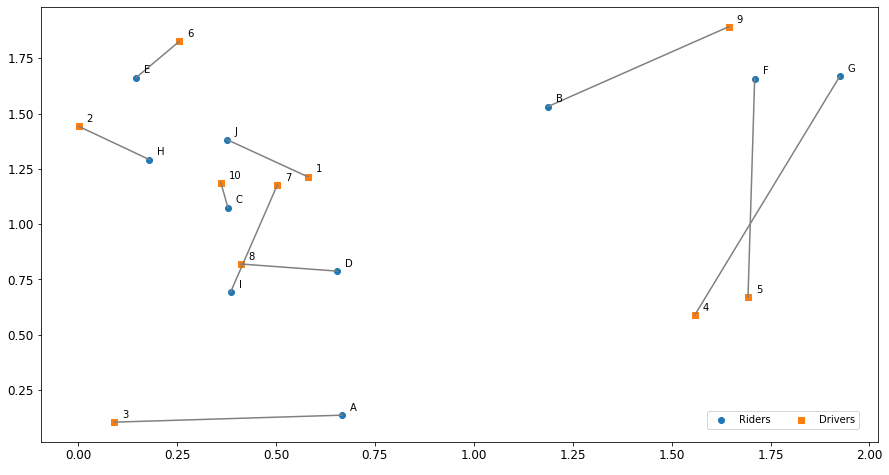

In [10]:
#@title Define a function to plot the assignment
def plot_assignment(assignment):

    # first plot the assignment
    ax = plt.figure(figsize=(15,8))

    # plot riders and annotate
    tol = 0.02
    plt.scatter( riders_df["Location_X"], riders_df["Location_Y"] )
    for r in riders:
        plt.annotate(r, (riders_df["Location_X"][r]+tol, \
                         riders_df["Location_Y"][r]+tol))

    # plot drivers and annotate
    plt.scatter( drivers_df["Location_X"], drivers_df["Location_Y"], marker="s" )
    for d in drivers:
        plt.annotate(d, (drivers_df["Location_X"][d]+tol, \
                         drivers_df["Location_Y"][d]+tol))

    ax.legend(labels = ['Riders','Drivers'], loc = 'upper right', \
              bbox_to_anchor=(0.8, 0.12), ncol=2)

    for r in riders:
        
        # get the numeric indices for the column where this is 1
        idx = np.where(assignment.loc[r,:]==1)[0]

        if idx.size :
            # the size is non-empty
            d = drivers[idx[0]]
            plt.plot( [drivers_df["Location_X"][d], riders_df["Location_X"][r] ],\
                     [drivers_df["Location_Y"][d], riders_df["Location_Y"][r] ], \
                     color='gray')
    plt.show()

#@markdown Use the function to plot the data scientist's assignment
plot_assignment(ds_match_df)

_____
# **Q2**

##  Create an empty model

In [11]:
# Gurobi model
Uber_Model = Model("Uber Assignment and Pricing")

Restricted license - for non-production use only - expires 2022-01-13


## Define the Decision Variables
In this problem, we would like to create a decision variable for every pair of (driver, rider). This is done easily using Gurobi's ``addVars`` method.

In [12]:
# decision variables for whether to assign a driver to a rider
assigned = Uber_Model.addVars( drivers, riders, name = "Assign", vtype=GRB.BINARY)

## Calculate and add the objective function

In [13]:
# Calculate the waiting time for each rider

waiting_times = {}
for r in riders:
    waiting_times[r] = quicksum( assigned[d,r]*distances_df[d][r] for d in drivers) / avg_speed

# average waiting time
average_waiting = quicksum( waiting_times[r] for r in riders ) / num_rider_requests

# objective: maximize the total coverage
Uber_Model.setObjective(average_waiting, GRB.MINIMIZE)

## Add All Constraints

In [14]:
# each rider requesting service is matched
for r in riders:
    Uber_Model.addConstr( quicksum(assigned[d,r] for d in drivers) == \
                         riders_df["Request_in"][r], "Rider_matched")

# each available driver assigned at most one rider
for d in drivers:
    Uber_Model.addConstr( quicksum(assigned[d,r] for r in riders) <= 1)

## Inspect the model


You can actually write the model out, which is useful for inspection. In this case the LP file may become large, so the code is commented out below. Feel free to un-comment the second line to see the output.

In [15]:
#@markdown Feel free to uncomment the next lines if you want to see the model printed
# Uber_Model.write("Uber_Model.lp")    # write the model to a file with extension ".lp"
# f = open("Uber_Model.lp", 'r')    # open a file handle
# print( f.read() )           # read the contents and print them
# f.close()              # close the file handle

## Solve the model

In [16]:
#@markdown Select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = True #@param {type:"boolean"}

if run_silently:
    Uber_Model.setParam('OutputFlag',0)
else:
    Uber_Model.setParam('OutputFlag',1)

Uber_Model.optimize()
print('\nSolved the optimization problem...')


Solved the optimization problem...


## Print and visualize the optimal solution


Assignment
Rider  : Driver
A      : 3
B      : 4
C      : 10
D      : 1
E      : 6
F      : 9
G      : 5
H      : 2
I      : 8
J      : 7


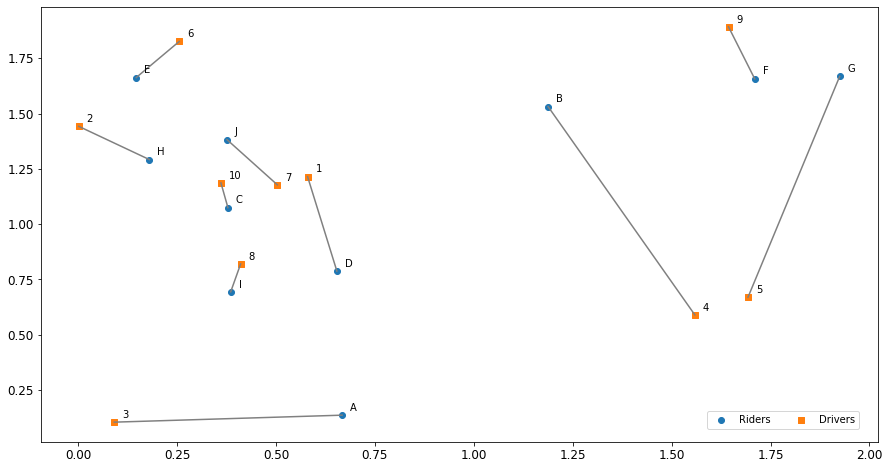


Waiting times
Rider  : Wait (min)     
A      : 1.92 
B      : 3.38 
C      : 0.38 
D      : 1.44 
E      : 0.65 
F      : 0.81 
G      : 3.42 
H      : 0.78 
I      : 0.43 
J      : 0.80 

Average wait time : 1.40 (min)


Driver incomes
Driver : Income ($)     
1      : 2.12 
2      : 5.44 
3      : 4.15 
4      : 4.77 
5      : 1.26 
6      : 3.92 
7      : 4.76 
8      : 2.03 
9      : 4.33 
10     : 3.22 

Average income : 3.60 ($)



In [17]:
#@title Define a function to print and visualize the assignment and its performance
def print_and_visualize(model, assignment_sol, print_sol_numbers=True,\
                        plot_the_matching=False):

    # print the schedule as a pandas dataframe
    pd.options.display.max_rows = 25
    df_assignment_sol = pd.DataFrame(dict( [ (d, [np.int(assignment_sol[d,r].X) for r in riders])\
                                   for d in drivers]), index=riders)
    # display(df_assignment_sol)
    if print_sol_numbers:
        print("="*100)
        print("\nAssignment")
        print("{:<6s} : {:<s}".format("Rider","Driver"))

        for r in riders:
            if riders_df["Request_in"][r] :
                matching_d = [d for d in drivers if df_assignment_sol[d][r]==1]
                print("{:<6s} : {:<d}".format(r, matching_d[0]))
            else:
                print("{:<6s} : {:<s}".format(r,"No request made."))

    # plot the assignment
    if plot_the_matching :
        plot_assignment(df_assignment_sol)

    print("="*100)
    print("\nWaiting times")
    print("{:<6s} : {:<15s}".format("Rider","Wait (min)"))

    for r in riders:
        if riders_df["Request_in"][r] :
            print("{:<6s} : {:<5.2f}".\
                  format(r,sum( df_assignment_sol[d][r]*distances_df[d][r] \
                                    for d in drivers) / avg_speed))
        else:
            print("{:<6s} : {:<s}".format(r,"No request made."))

    print("\nAverage wait time : {:.2f} (min)\n".\
          format(sum(df_assignment_sol[d][r]*distances_df[d][r] for d in drivers \
                     for r in riders) / (avg_speed*num_rider_requests)))
    
    print("="*100)
    print("\nDriver incomes")
    print("{:<6s} : {:<15s}".format("Driver","Income ($)"))

    for d in drivers:
        print("{:<6d} : {:<5.2f}".\
              format(d,sum( df_assignment_sol[d][r]*riders_df["Distance_to_destination"][r] \
                           for r in riders) * fare_per_km * driver_share_revenue))

    print("\nAverage income : {:.2f} ($)\n".\
          format(sum( df_assignment_sol[d][r]*riders_df["Distance_to_destination"][r] for d in drivers \
                      for r in riders)*fare_per_km*driver_share_revenue/num_drivers))

#@markdown Use the function to print the results
#@markdown - select whether to also plot the assignment
plot_the_matching = True #@param {type:"boolean"}

print_and_visualize(Uber_Model, assigned, print_sol_numbers=True, \
                    plot_the_matching=plot_the_matching)


## Create a few utility functions that will help subsequently

To help with subsequent parts of the problem, we also add all the steps above inside a **function** that returns a generic model like the one we created in **Q2**, together with all the decision variables and the waiting times for all riders.

In [18]:
#@title A function that generates a model like the one in **Q2**
def create_model_like_in_Q2():
    # Gurobi model
    Uber_Model = Model("Uber Assignment and Pricing")

    # decision variables for how much to ship from each factory to each customization center
    assigned = Uber_Model.addVars( drivers, riders, name = "Assign", vtype=GRB.BINARY)

    # Calculate the waiting time for each rider

    waiting_times = {}
    for r in riders:
        waiting_times[r] = quicksum( assigned[d,r]*distances_df[d][r] for d in drivers) / avg_speed

    # average waiting time
    average_waiting = quicksum( waiting_times[r] for r in riders ) / num_rider_requests

    # objective: maximize the total coverage
    Uber_Model.setObjective(average_waiting, GRB.MINIMIZE)

    # each rider requesting service is matched
    matched_riders = {}
    for r in riders:
        matched_riders[r] = Uber_Model.addConstr( quicksum(assigned[d,r] for d in drivers) == \
                            riders_df["Request_in"][r], "Rider_matched")

    # each available driver assigned at most one rider
    for d in drivers:
        Uber_Model.addConstr( quicksum(assigned[d,r] for r in riders) <= 1)

    # return the model, the decision variables, the individual coverage calculations
    return Uber_Model,  assigned, waiting_times, matched_riders

______
# **Q3**
Before running this section, make sure you have run all the previous sections of the Colab file.

Re-recreate an identical model to the one from **Q2** and store the expression for model, the decision variables and the waiting times.

In [19]:
#@markdown Create a model like the one in Q2 using the function 
Uber_Model,  assigned, waiting_times, matched_riders = create_model_like_in_Q2()

Add a new decision variable for the maximum waiting time incurrent by any rider.

In [20]:
#@markdown New decision variable for max wait time
max_wait = Uber_Model.addVar(name="Max_wait")

Change the objective to minimize the maximum wait (the new variable).

In [21]:
#@markdown Change the objective to minimize maximum wait
Uber_Model.setObjective( max_wait, GRB.MINIMIZE )

Add constraints that the maximum wait is at least as large as the wait for any rider

In [22]:
#@markdown Add constraints that the max wait variable exceeds the wait of each customer
for r in riders:
    Uber_Model.addConstr( max_wait >= waiting_times[r], name = "Max_exceeds")

Solve the model

In [23]:
#@markdown Select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = True #@param {type:"boolean"}

if run_silently:
    Uber_Model.setParam('OutputFlag',0)
else:
    Uber_Model.setParam('OutputFlag',1)

Uber_Model.optimize()
print('\nSolved the optimization problem...')


Solved the optimization problem...


Print the optimal solution.

The smallest maximum wait achieved: 3.29 (min)

Assignment
Rider  : Driver
A      : 3
B      : 7
C      : 1
D      : 4
E      : 2
F      : 5
G      : 9
H      : 10
I      : 8
J      : 6


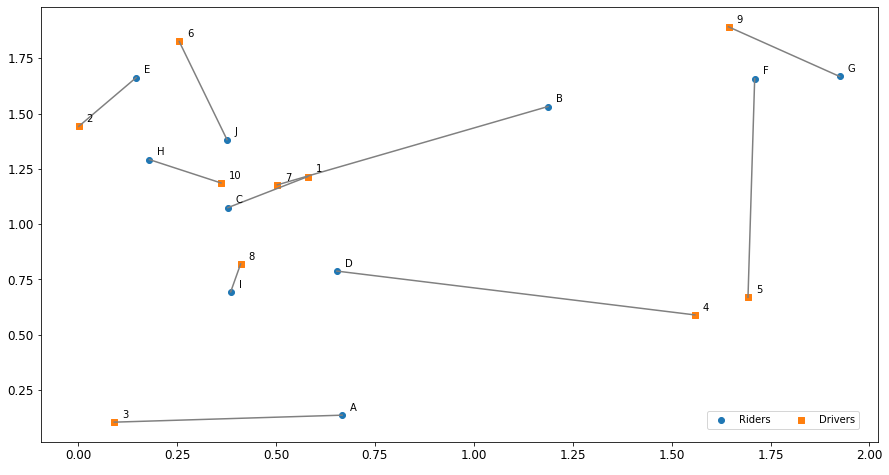


Waiting times
Rider  : Wait (min)     
A      : 1.92 
B      : 2.57 
C      : 0.82 
D      : 3.09 
E      : 0.88 
F      : 3.29 
G      : 1.20 
H      : 0.70 
I      : 0.43 
J      : 1.53 

Average wait time : 1.64 (min)


Driver incomes
Driver : Income ($)     
1      : 3.22 
2      : 3.92 
3      : 4.15 
4      : 2.12 
5      : 4.33 
6      : 4.76 
7      : 4.77 
8      : 2.03 
9      : 1.26 
10     : 5.44 

Average income : 3.60 ($)



In [24]:
print("The smallest maximum wait achieved: {:.2f} (min)".format(max_wait.X))

print_and_visualize(Uber_Model, assigned, print_sol_numbers=True, \
                    plot_the_matching=True)

### **OPTIONAL:** Re-optimize the average waiting time with a constraint on the maximum waiting time

In [25]:
# store the optimal value (smallest maximum waiting time)
smallest_max_wait = max_wait.X

# create a model like the one in Q1 using the function 
Uber_Model,  assigned, waiting_times, matched_riders = create_model_like_in_Q2()
# add constraints that the wait for each rider should not exceed the max wait
for r in riders:
    Uber_Model.addConstr( waiting_times[r] <= smallest_max_wait, name = "Max_wait")

Solve the model

In [26]:
#@markdown Select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = True #@param {type:"boolean"}

if run_silently:
    Uber_Model.setParam('OutputFlag',0)
else:
    Uber_Model.setParam('OutputFlag',1)

Uber_Model.optimize()
print('\nSolved the optimization problem...')


Solved the optimization problem...


Print the optimal solution.


Assignment
Rider  : Driver
A      : 3
B      : 1
C      : 10
D      : 4
E      : 6
F      : 5
G      : 9
H      : 2
I      : 8
J      : 7


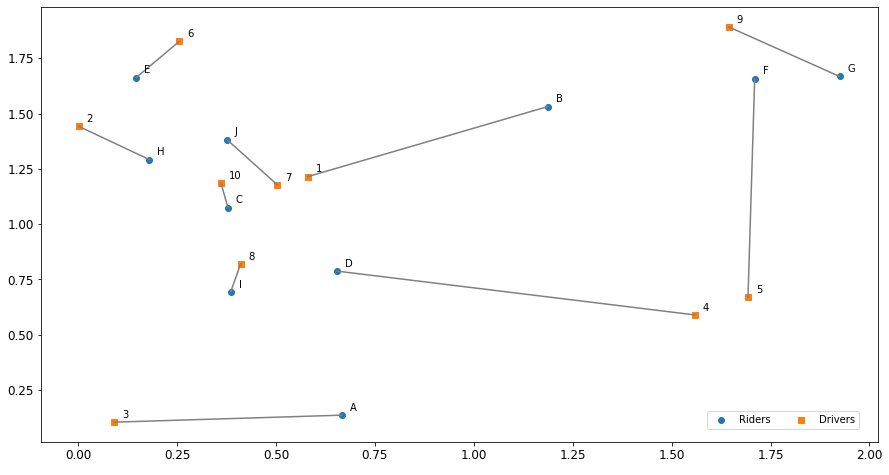


Waiting times
Rider  : Wait (min)     
A      : 1.92 
B      : 2.29 
C      : 0.38 
D      : 3.09 
E      : 0.65 
F      : 3.29 
G      : 1.20 
H      : 0.78 
I      : 0.43 
J      : 0.80 

Average wait time : 1.48 (min)


Driver incomes
Driver : Income ($)     
1      : 4.77 
2      : 5.44 
3      : 4.15 
4      : 2.12 
5      : 4.33 
6      : 3.92 
7      : 4.76 
8      : 2.03 
9      : 1.26 
10     : 3.22 

Average income : 3.60 ($)



In [27]:
# Use the function to print the results
print_and_visualize(Uber_Model, assigned, print_sol_numbers=True, \
                    plot_the_matching=True)

______
# **Q4**
Before running this section, make sure you have run all the previous sections of the Colab file.

Store a few new parameters relevant here.

In [28]:
# new parameters relevant here
max_willingness_to_wait = 1.5

Re-recreate an identical model to the one from **Q2** and store the expression for model, the decision variables and the waiting times.

In [29]:
#@markdown Create a model like the one in Q2 using the function 
Uber_Model,  assigned, waiting_times, matched_riders = create_model_like_in_Q2()

Add new binary decision variables for whether a rider request is successfully completed (which is the same as the waiting time incurred by the rider not exceeding the max willingness to wait)

In [30]:
#@markdown New decision variable for whether max wait exceeded
request_completed = Uber_Model.addVars(riders, name="Request_completed", \
                                      vtype=GRB.BINARY)

Change the objective to maximize the number of bookings.

In [31]:
#@markdown Change the objective to minimize maximum wait
Uber_Model.setObjective( quicksum(request_completed[r] for r in riders), GRB.MAXIMIZE )

Add constraints that if a request from a rider is successfully completed, the wait time should not exceed the maximum willingness to wait)

In [32]:
#@markdown Add constraints that the wait time should not exceed max willingness to wait

# store a very large value to use in the constraint
huge_value = 100

for r in riders:
    Uber_Model.addConstr( waiting_times[r] <= \
                         request_completed[r]*max_willingness_to_wait + \
                         (1-request_completed[r])*huge_value )

In [33]:
#@markdown Feel free to uncomment the next lines if you want to see the model printed
Uber_Model.write("Uber_Model.lp")    # write the model to a file with extension ".lp"
f = open("Uber_Model.lp", 'r')    # open a file handle
print( f.read() )           # read the contents and print them
f.close()              # close the file handle

\ Model Uber Assignment and Pricing
\ LP format - for model browsing. Use MPS format to capture full model detail.
Maximize
  Request_completed[A] + Request_completed[B] + Request_completed[C]
   + Request_completed[D] + Request_completed[E] + Request_completed[F]
   + Request_completed[G] + Request_completed[H] + Request_completed[I]
   + Request_completed[J]
Subject To
 Rider_matched: Assign[1,A] + Assign[2,A] + Assign[3,A] + Assign[4,A]
   + Assign[5,A] + Assign[6,A] + Assign[7,A] + Assign[8,A] + Assign[9,A]
   + Assign[10,A] = 1
 Rider_matched: Assign[1,B] + Assign[2,B] + Assign[3,B] + Assign[4,B]
   + Assign[5,B] + Assign[6,B] + Assign[7,B] + Assign[8,B] + Assign[9,B]
   + Assign[10,B] = 1
 Rider_matched: Assign[1,C] + Assign[2,C] + Assign[3,C] + Assign[4,C]
   + Assign[5,C] + Assign[6,C] + Assign[7,C] + Assign[8,C] + Assign[9,C]
   + Assign[10,C] = 1
 Rider_matched: Assign[1,D] + Assign[2,D] + Assign[3,D] + Assign[4,D]
   + Assign[5,D] + Assign[6,D] + Assign[7,D] + Assign[8,D] + 

Solve the model

In [34]:
#@markdown Select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = False #@param {type:"boolean"}

if run_silently:
    Uber_Model.setParam('OutputFlag',0)
else:
    Uber_Model.setParam('OutputFlag',1)

Uber_Model.optimize()
print('\nSolved the optimization problem...')

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 30 rows, 110 columns and 310 nonzeros
Model fingerprint: 0x06b04a21
Variable types: 0 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [4e-01, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 1.0000000
Presolve removed 6 rows and 6 columns
Presolve time: 0.00s
Presolved: 24 rows, 104 columns, 237 nonzeros
Variable types: 0 continuous, 104 integer (104 binary)

Root relaxation: objective 7.675433e+00, 36 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    7.67543    0    1    1.00000    7.67543   668% 

Print the optimal solution.

In [35]:
#@markdown Use the function to print the results

print("The number of successful rides completed:  {:d}".format(np.int(Uber_Model.objVal)))

print("Requests completed successfully: ")
for r in riders:
   if request_completed[r].X==1 :
      print(r)

print_and_visualize(Uber_Model, assigned, print_sol_numbers=True, \
                    plot_the_matching=False)

The number of successful rides completed:  7
Requests completed successfully: 
C
D
E
F
H
I
J

Assignment
Rider  : Driver
A      : 4
B      : 3
C      : 10
D      : 1
E      : 6
F      : 9
G      : 5
H      : 2
I      : 8
J      : 7

Waiting times
Rider  : Wait (min)     
A      : 3.33 
B      : 6.00 
C      : 0.38 
D      : 1.44 
E      : 0.65 
F      : 0.81 
G      : 3.42 
H      : 0.78 
I      : 0.43 
J      : 0.80 

Average wait time : 1.80 (min)


Driver incomes
Driver : Income ($)     
1      : 2.12 
2      : 5.44 
3      : 4.77 
4      : 4.15 
5      : 1.26 
6      : 3.92 
7      : 4.76 
8      : 2.03 
9      : 4.33 
10     : 3.22 

Average income : 3.60 ($)



______
# **Q5**
Before running this section, make sure you have run all the previous sections of the Colab file.

In [36]:
# read in the new data relevant here
# data for Q5
districts_df = pd.read_excel("Uber_Data.xlsx", sheet_name = "Q6_data", index_col=0)
print("The data on pricing")
display(districts_df)

# create a list of riders who may not request service
districts = list(districts_df.index)
print("The districts:")
print(districts)

# also store the parameter on maximum average wait
avg_wait_max = 4.0
drivers_gained_per_surge = 5.0
riders_lost_per_surge = 3.0
max_surge_level = 3.0

The data on pricing


,1,2,3,4,5,6,7,8,Riders,Drivers
District,,,,,,,,,,
1,0.00,3.20,4.10,6.50,7.90,9.10,8.10,10.20,11,2
2,3.20,0.00,5.10,4.90,8.10,6.20,11.90,9.10,13,2
3,4.10,5.10,0.00,2.60,2.90,3.40,5.30,7.20,23,0
4,6.50,4.90,2.60,0.00,3.20,2.60,5.10,4.40,11,0
5,7.90,8.10,2.90,3.20,0.00,2.30,2.80,4.20,10,4
6,9.10,6.20,3.40,2.60,2.30,0.00,3.10,2.80,15,5
7,8.10,11.90,5.30,5.10,2.80,3.10,0.00,2.10,24,2
8,10.20,9.10,7.20,4.40,4.20,2.80,2.10,0.00,19,0


The districts:
[1, 2, 3, 4, 5, 6, 7, 8]


Re-recreate an identical model to the one from **Q2** and store the expression for model, the decision variables and the waiting times.

In [37]:
# Create a model

# Gurobi model
Uber_Model = Model("Uber Assignment and Pricing")

# decision variables for how many drivers to dispatch from one district to the next
assigned = Uber_Model.addVars( districts, districts, name = "Assign", vtype=GRB.INTEGER)

# decision variables for surge level
surge_level = Uber_Model.addVars( districts, name = "Surge")

# Change the objective to maximize successful bookings
bookings = quicksum(assigned[d,r] for d in districts for r in districts)
Uber_Model.setObjective( bookings, GRB.MAXIMIZE )

# Constraint that average waiting time cannot exceed the upper limit
# to make this linear, we write it as:
#     total waiting time  <= max_wait_limit * number_of_customers_picked
Uber_Model.addConstr( quicksum( assigned[d,r]*districts_df[d][r] for d in districts for r in districts)\
                   <= avg_wait_max * bookings, name="Avg_wait" )

# constraint on maximum surge level
for d in districts:
  Uber_Model.addConstr(surge_level[d] <= max_surge_level )

# Bookings in each district cannot exceed the number of riders requesting service 
for r in districts:
  Uber_Model.addConstr( quicksum(assigned[d,r] for d in districts) <= \
                       districts_df["Riders"][r] - surge_level[r]*riders_lost_per_surge)

# Bookings cannot exceed the number of riders available
for d in districts:
  Uber_Model.addConstr( quicksum(assigned[d,r] for r in districts) <= \
                       districts_df["Drivers"][d] + surge_level[d]*drivers_gained_per_surge)

In [38]:
#@markdown Feel free to uncomment the next lines if you want to see the model printed
# Uber_Model.write("Uber_Model.lp")    # write the model to a file with extension ".lp"
# f = open("Uber_Model.lp", 'r')    # open a file handle
# print( f.read() )           # read the contents and print them
# f.close()              # close the file handle

Solve the model

In [39]:
#@markdown Select whether to run the [Gurobi](https://www.gurobi.com/) optimization algorithms silently (no output details)
run_silently = True #@param {type:"boolean"}

if run_silently:
    Uber_Model.setParam('OutputFlag',0)
else:
    Uber_Model.setParam('OutputFlag',1)

Uber_Model.optimize()
print('\nSolved the optimization problem...')


Solved the optimization problem...


Print the optimal solution.

In [40]:
# Print the results

print("The number of successful rides completed:  {:d}".\
      format(np.int(Uber_Model.objVal)))

print("Surge levels: ")
for d in districts:
    print("District {} : {}".format(d,surge_level[d].X))

print("="*100)
print("\nAssignment")
for d in districts:

   print("District : {}".format(d))
   print('\tAvailable drivers: {}'.\
         format(districts_df["Drivers"][d] + surge_level[d].X*drivers_gained_per_surge))

   print("\tDispatched:")
   for r in districts:
      if assigned[d,r].X > 0:
         print("\t\t to {} : {}".format(r,assigned[d,r].X))

print("="*100)
print("\nAverage waiting time: {}".\
      format( sum(assigned[d,r].X*districts_df[d][r] for d in districts for r in districts)\
                   /bookings.getValue()))

The number of successful rides completed:  84
Surge levels: 
District 1 : 1.0
District 2 : 0.0
District 3 : 2.6
District 4 : 3.0
District 5 : 0.3333333333333333
District 6 : 3.0
District 7 : 3.0
District 8 : 1.0

Assignment
District : 1
	Available drivers: 7.0
	Dispatched:
		 to 1 : 7.0
District : 2
	Available drivers: 2.0
	Dispatched:
		 to 8 : 2.0
District : 3
	Available drivers: 13.0
	Dispatched:
		 to 1 : 1.0
		 to 2 : 12.0
District : 4
	Available drivers: 15.0
	Dispatched:
		 to 3 : 15.0
District : 5
	Available drivers: 5.666666666666666
	Dispatched:
		 to 4 : 1.0
		 to 5 : 4.0
District : 6
	Available drivers: 20.0
	Dispatched:
		 to 6 : 6.0
		 to 8 : 14.0
District : 7
	Available drivers: 17.0
	Dispatched:
		 to 2 : 1.0
		 to 4 : 1.0
		 to 7 : 15.0
District : 8
	Available drivers: 5.0
	Dispatched:
		 to 5 : 5.0

Average waiting time: 2.4154761904761903
